# Flower Simulation with TensorFlow/Keras

Welcome to Flower, a friendly federated learning framework!

In this notebook we will:

*  Perform data pre-processing using an AML dataset
*  Simulate a federated learning system with 10 clients using Tensorflow/Keras.
*  Compare the simulated systems results with a standard/classical deep learning model.


Let's start by installing Flower (published as `flwr` on PyPI) with the simulation` extra:

In [1]:
!pip install -q flwr["simulation"] tensorflow
!pip install -q flwr_datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.1/330.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 10.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Let's also install Matplotlib so we can make some plots once the simulation is completed

In [2]:
!pip install matplotlib

Next, we will install all the necessary libraries for this experiment.

In [3]:
from typing import Dict, List, Tuple
import tensorflow as tf
import flwr as fl
from flwr.common import Metrics
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth
from datasets import Dataset
from flwr_datasets import FederatedDataset
from google.colab import drive
import pandas as pd
import numpy as np
import flwr as fl
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


VERBOSE = 0

### Data Pre-Processing

The dataset is imported from Google drive. As it is a large dataset, it can take some time to load. The dataset is sourced from:

https://www.kaggle.com/datasets/berkanoztas/synthetic-transaction-monitoring-dataset-aml?resource=download


In [4]:
#Mount Google Drive
drive.mount('/content/drive')
dataset_path = '/content/drive/My Drive/Master Data Science/(8) Team Project (A) - Project Management and Practices/Synthetic Data/Mimesis/SAML-D.csv'
dataset_df = pd.read_csv(dataset_path)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/drive


The next step is pre-processing the data for the modelling process. As there is such a large class imbalance, undersampling of the majority class (fraud = 0) is completed to avoid the model producing very high accuracy.

Once pre-processing is done, the partitions are created from the train dataset. The partitions represent clients i.e. banks but in a real world scenario, this would not take place. The code below is an experiment to showcase how federated learning works and if it produces better results than classical machine learning.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np


def undersample_majority_class(data_df, ratio=3):
    """Undersample the majority class to achieve a specified ratio."""
    # Separate majority and minority classes
    majority_class = data_df[data_df['Is_laundering'] == 0]
    minority_class = data_df[data_df['Is_laundering'] == 1]

    # Calculate target size for the majority class
    target_size_majority = len(minority_class) * ratio

    # Undersample majority class to match target size
    undersampled_majority_class = majority_class.sample(n=target_size_majority, replace=True, random_state=42)

    # Combine undersampled majority class and minority class
    undersampled_data = pd.concat([undersampled_majority_class, minority_class], axis=0)

    return undersampled_data


# Reduced Dataset i.e. remove columns
selected_columns = ['Sender_account', 'Receiver_account', 'Amount', 'Payment_type', 'Is_laundering']
dataset_df_red = dataset_df[selected_columns]

# One hot encoding
dataset_df_OHE = pd.get_dummies(dataset_df_red, columns=['Payment_type'])

# Convert boolean values to integers (1s and 0s)
dataset_df_OHE = dataset_df_OHE.astype(int)

# Re-arrange columns
dataset_df_updated = dataset_df_OHE.reindex(columns=[col for col in dataset_df_OHE.columns if col != 'Is_laundering'] + ['Is_laundering'])

# Undersample majority class
dataset_df_balanced = undersample_majority_class(dataset_df_updated)

# Scale data
scaler = MinMaxScaler()
dataset_df_scaled = pd.DataFrame(scaler.fit_transform(dataset_df_balanced), columns=dataset_df_balanced.columns)

# Train-test split
train_df, test_df = train_test_split(dataset_df_scaled, test_size=0.1, random_state=42)

# Convert to numpy arrays
train_features = train_df.drop(columns=["Is_laundering"]).values
train_labels = train_df["Is_laundering"].values

test_features = test_df.drop(columns=["Is_laundering"]).values
test_labels = test_df["Is_laundering"].values

# Combine features and labels for the training dataset
train_data = np.concatenate((train_features, train_labels.reshape(-1, 1)), axis=1)

# Combine features and labels for the test dataset
test_data = np.concatenate((test_features, test_labels.reshape(-1, 1)), axis=1)

# Create Partitions
num_partitions = 10
partitions = []
partition_size = len(train_data) // num_partitions

for i in range(num_partitions):
    start_idx = i * partition_size
    end_idx = (i + 1) * partition_size
    partition_data = train_data[start_idx:end_idx]
    partitions.append(partition_data)

NUM_CLIENTS = num_partitions


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# Number of samples in train data
num_train_samples = train_data.shape[0]
print("Number of samples in train data:", num_train_samples)

# Number of samples in test data
num_test_samples = test_data.shape[0]
print("Number of samples in test data:", num_test_samples)


Number of samples in train data: 35542
Number of samples in test data: 3950


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Note: this experiment is run on GPU. Please change runtype to GPU if possible.

In [7]:
!pip install tensorflow-gpu

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


### Flower Simulation

The code below defines the model for training, creates the flower client class, function for creating the clients, functions for metric analysis and evaluation and a definition of the strategy and history of results for visualisation.

In [8]:
# Define the model
def get_model():
    """Constructs a simple binary classification model."""
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(10,)),  # Specify input shape (10,)
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# FlowerClient class
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, trainset, valset) -> None:
        # Create model
        self.model = get_model()
        self.trainset = trainset
        self.valset = valset

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        train_features = self.trainset[:, :-1]  # Extract features
        train_labels = self.trainset[:, -1]  # Extract labels
        self.model.fit(train_features, train_labels, epochs=1, verbose=VERBOSE)
        return self.model.get_weights(), len(train_features), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        val_features = self.valset[:, :-1]  # Extract features
        val_labels = self.valset[:, -1]  # Extract labels
        loss, acc = self.model.evaluate(val_features, val_labels, verbose=VERBOSE)
        return loss, len(val_features), {"accuracy": acc}


# Function to create a client
def get_client_fn(partitions: List[np.ndarray], testset: np.ndarray):
    """Return a function to construct a client."""
    def client_fn(cid: str) -> fl.client.Client:
        """Construct a FlowerClient with its own dataset partition."""
        partition = partitions[int(cid)]
        trainset, valset = partition, testset

        # Create and return client
        return FlowerClient(trainset, valset).to_client()

    return client_fn

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    """Aggregation function for (federated) evaluation metrics, i.e. those returned by
    the client's evaluate() method."""
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}




# Function for server-side evaluation
def get_evaluate_fn(testset: np.ndarray):
    """Return an evaluation function for server-side evaluation."""
    def evaluate(server_round: int, parameters: fl.common.NDArray, config: Dict[str, fl.common.Scalar]):
        model = get_model()
        model.set_weights(parameters)

        val_features = testset[:, :-1]  # Extract features
        val_labels = testset[:, -1]  # Extract labels
        loss, accuracy = model.evaluate(val_features, val_labels, verbose=VERBOSE)
        return loss, {"accuracy": accuracy}

    return evaluate


# Define the number of clients
NUM_CLIENTS = 10


# Enable GPU usage in TensorFlow
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


# Create FedAvg strategy with weighted average aggregation function
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.1,
    fraction_evaluate=0.05,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=int(NUM_CLIENTS * 0.75),
    evaluate_metrics_aggregation_fn=weighted_average,
    evaluate_fn=get_evaluate_fn(test_data),
)



# Define client resources
client_resources = {"num_cpus": 1, "num_gpus": 1.0}

# Start simulation
history = fl.simulation.start_simulation(
    client_fn=get_client_fn(partitions, test_data),
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=strategy,
    client_resources=client_resources,
    actor_kwargs={"on_actor_init_fn": enable_tf_gpu_growth}
)


Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
INFO:flwr:Starting Flower simulation, config: num_rounds=10, no round_timeout


1 Physical GPUs, 1 Logical GPUs


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-05-03 04:19:29,459	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 3954079334.0, 'memory': 7908158670.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'object_store_memory': 3954079334.0, 'memory': 7908158670.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'CPU': 2.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_

The history object shows the results of the 10 rounds with an accuracy around 78%.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


history.metrics_centralized = {'accuracy': [(0, 0.6382278203964233), (1, 0.7572152018547058), (2, 0.7762025594711304), (3, 0.7812657952308655), (4, 0.7762025594711304), (5, 0.7762025594711304), (6, 0.7762025594711304), (7, 0.7767088413238525), (8, 0.7764557003974915), (9, 0.7782278656959534), (10, 0.7764557003974915)]}


Text(0.5, 1.0, 'Fraud Detection - 10 clients with 10 clients per round.')

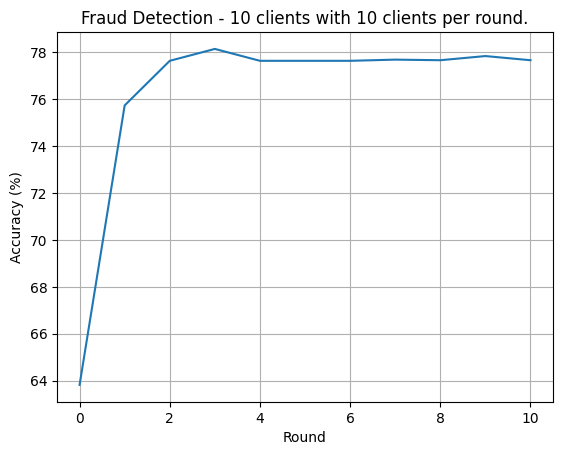

In [9]:
import matplotlib.pyplot as plt

print(f"{history.metrics_centralized = }")

global_accuracy_centralised = history.metrics_centralized["accuracy"]
round = [data[0] for data in global_accuracy_centralised]
acc = [100.0 * data[1] for data in global_accuracy_centralised]
plt.plot(round, acc)
plt.grid()
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.title("Fraud Detection - 10 clients with 10 clients per round.")

### Training without Federated Learning

A subset of the training data will be created and used for training the model locally. The results will be compared with the federated learning simulation.

In [10]:
# randomly shuffle the array
np.random.seed(42)  # for reproducibility
np.random.shuffle(train_data)

# calculate the number of samples for 20%
train_data_20_percent = int(len(train_data) * 0.2)

# select the first 20% of the shuffled data for training
sub_training_data = train_data[:train_data_20_percent]

In [11]:
# Determine the index of the last column
last_column_index = sub_training_data.shape[1] - 1

# Create a subset of features excluding the last column (label column)
sub_train_features = np.delete(sub_training_data, last_column_index, axis=1)
sub_train_labels = sub_training_data[:, -1]


In [12]:
print("Shape of sub_train_dataset:", sub_training_data.shape)
print("Shape of sub_train_features:", sub_train_features.shape)
print("Shape of sub_train_labels:", sub_train_labels.shape)

Shape of sub_train_dataset: (7108, 11)
Shape of sub_train_features: (7108, 10)
Shape of sub_train_labels: (7108,)


In [13]:
sub_train_features, sub_val_features, sub_train_labels, sub_val_labels = train_test_split(sub_train_features, sub_train_labels, test_size=0.2, random_state=42)

In [14]:
#Train the model locally using the sub-training dataset
model_local = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(10,)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

model_local.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

model_local.fit(sub_train_features, sub_train_labels, epochs=1, batch_size=32, verbose=1)


178/178 [==============================] - 4s 3ms/step - loss: 0.5382 - accuracy: 0.7337


In [15]:
#Evaluate the locally trained model on the validation dataset
loss_local, accuracy_local = model_local.evaluate(sub_val_features, sub_val_labels, verbose=1)
print("Local model - Validation Loss:", loss_local)
print("Local model - Validation Accuracy:", accuracy_local)


45/45 [==============================] - 0s 3ms/step - loss: 0.5039 - accuracy: 0.7644
Local model - Validation Loss: 0.5038970708847046
Local model - Validation Accuracy: 0.7644163370132446


### Evaluation

The notebook successfully performed a federated learning simulation using flower and a standard local model without federated learning.

The results show that the accuracy using federated learning was around 78% compared with 76% without using federated learning. This indicates that **for this dataset,** federated learning did not improve the accuracy of the predictions. There might be some valid reasons for this such as:


*   Class imbalance issues
*   Reduced feature input
*   Other metrics might be more useful
*   Model only trained with one epoch.

Given the results, there is scope to expand upon this experiment to incorporate multiple datasets (synthetic or real) instead of partitioning one large dataset, attempt different model types such as logistic regression or gradient boosted trees and customise the strategies and client side execution through config dictionaries.

The limitations of using a cloud based environment such as Colab for running these experiments (or even real world scenarios) are very slow processing times, high memory usage and data privacy concern with uploading data. The advantages are the accessibility making it easy to get started, GPU support and intergration with flower frameworks.

Some useful documenation for further research includes:

* Flower documenation: https://flower.ai/docs/
* Flower datasets (used for this experiment): https://flower.ai/docs/datasets/
* Original flower simulation: https://colab.research.google.com/github/adap/flower/blob/main/examples/simulation-tensorflow/sim.ipynb
* Flower examples: https://flower.ai/docs/examples/
* Youtube channel: https://www.youtube.com/@flowerlabs